## Truncate generation times distribution
Here, we will truncate the generation times distribution,
to avoid the need always to make the calculations
over the full simulation period at each time step.
Considering all time points prior to the 
time of interest is unlikely to be desirable
for longer (including real-world) analyses.
All functions except for `semimech` and 
`get_gamma_densities_from_params`
are unchanged from the previous notebook, 
other than feeding through one additional argument
for the number of generation times to use.

Note that I did try out the approach of
calculating the truncation time for the generation
time distribution within the model function,
such that it could be determined by the 
distribution being used. However, this resulted 
in the optimisations all going completely haywire.
Although I'm not quite sure why this happened,
this version is probably fine for our purposes
and allowing for adaptive truncations is probably
unnecessary.

In [1]:
from typing import Dict, List
from collections import namedtuple
from scipy.stats import gamma
import numpy as np
import pandas as pd
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize, shgo

In [2]:
Outputs = namedtuple('outputs', ['incidence', 'suscept', 'r_t'])

def semimech(gen_time_densities, process_vals, pop, seed, n_times, gen_times_end) -> Outputs:
    """The semimechanistic process.
    """
    incidence = np.zeros(n_times)
    suscept = np.zeros(n_times)
    r_t = np.zeros(n_times)

    incidence[0] = seed
    suscept[0] = pop - seed
    r_t[0] = np.nan
    
    for t in range(1, n_times):

        # Calculations
        gen_times_interest = min(t, gen_times_end)  # Number of generation times relevant to current loop
        inc_vals = incidence[t - gen_times_interest :t]  # Incidence series
        gen_vals = gen_time_densities[:gen_times_interest]  # Generation series
        contribution_by_day = inc_vals * gen_vals[::-1]  # Product of incidence values and reversed generation times
        infect_modifier = process_vals[t] * suscept[t - 1] / pop  # Pre-specified process by the proportion susceptible
        this_inc = contribution_by_day.sum() * infect_modifier  # Incidence for this time point
        this_suscept = max(suscept[t - 1] - this_inc, 0.0)  # Zero out any small negative susceptible values

        # Output tracking
        incidence[t] = this_inc
        suscept[t] = this_suscept
        r_t[t] = gen_vals.sum() * infect_modifier

    return Outputs(incidence, suscept, r_t)


def get_gamma_params_from_mean_sd(req_mean: float, req_sd: float) -> Dict[str, float]:
    """Get values for constructive the gamma distribution from user requested mean and standard deviation.
    """
    var = req_sd ** 2.0
    scale = var / req_mean
    a = req_mean / scale
    return {'a': a, 'scale': scale}

def get_gamma_densities_from_params(mean: float, sd: float, n_times: int) -> np.array:
    """Get integrals over integer differences in gamma distribution for simulation duration.
    """
    params = get_gamma_params_from_mean_sd(mean, sd)
    return np.diff(gamma.cdf(range(n_times + 1), **params))

def get_interp_vals_over_model_time(req: List[float], n_times: int) -> np.array:
    """Linear interpolation at requested values at regular intervals over simulation period.
    """
    return np.interp(range(n_times), np.linspace(0.0, n_times, len(req)), req)

def model_func(gen_time_mean: float, gen_time_sd: float, process_req: List[float], pop: int, seed: int, n_times: int, gen_times_end: int) -> tuple:
    """The other epidemiological aspects of the model.
    """
    gen_time_densities = get_gamma_densities_from_params(gen_time_mean, gen_time_sd, gen_times_end)
    process_vals = get_interp_vals_over_model_time(process_req, n_times)
    model_result = semimech(gen_time_densities, process_vals, pop, seed, n_times, gen_times_end)
    return model_result, process_vals 

def all_param_calib_func(parameters: List[float], pop: int, seed: int, n_times: int, targets: dict, ) -> float:
    """Get the loss function from the model.
    """
    gen_time_mean, gen_time_sd, *process_req = parameters
    incidence = model_func(gen_time_mean, gen_time_sd, process_req, pop, seed, n_times, gen_times_end)[0][0]
    return sum([(incidence[t] - d) ** 2 for t, d in targets.items()])

def plot_output_fit(targets: Dict[int, float], result: Outputs, process_vals):
    """Plot results from a fitting attempt against the target data and show estimated random process.
    """
    fitted, suscept, r_t = result
    model_times = pd.Series(range(n_times))
    fig = make_subplots(3, 1, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=['incidence', 'reproduction number', 'susceptibles'])
    fig.add_trace(go.Scatter(x=list(targets.keys()), y=list(targets.values()), mode='markers', name='targets'), row=1, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=fitted, name='model'), row=1, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=process_vals, name='transmission potential'), row=2, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=r_t, name='Rt'), row=2, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=suscept, name='susceptibles'), row=3, col=1)
    return fig.update_layout(height=800, margin={'t': 20, 'b': 5, 'l': 5, 'r': 5})

### Optimisation with above model adaptations
Simple, arbitrary parameters and targetsSimple, arbitrary parameters and targets

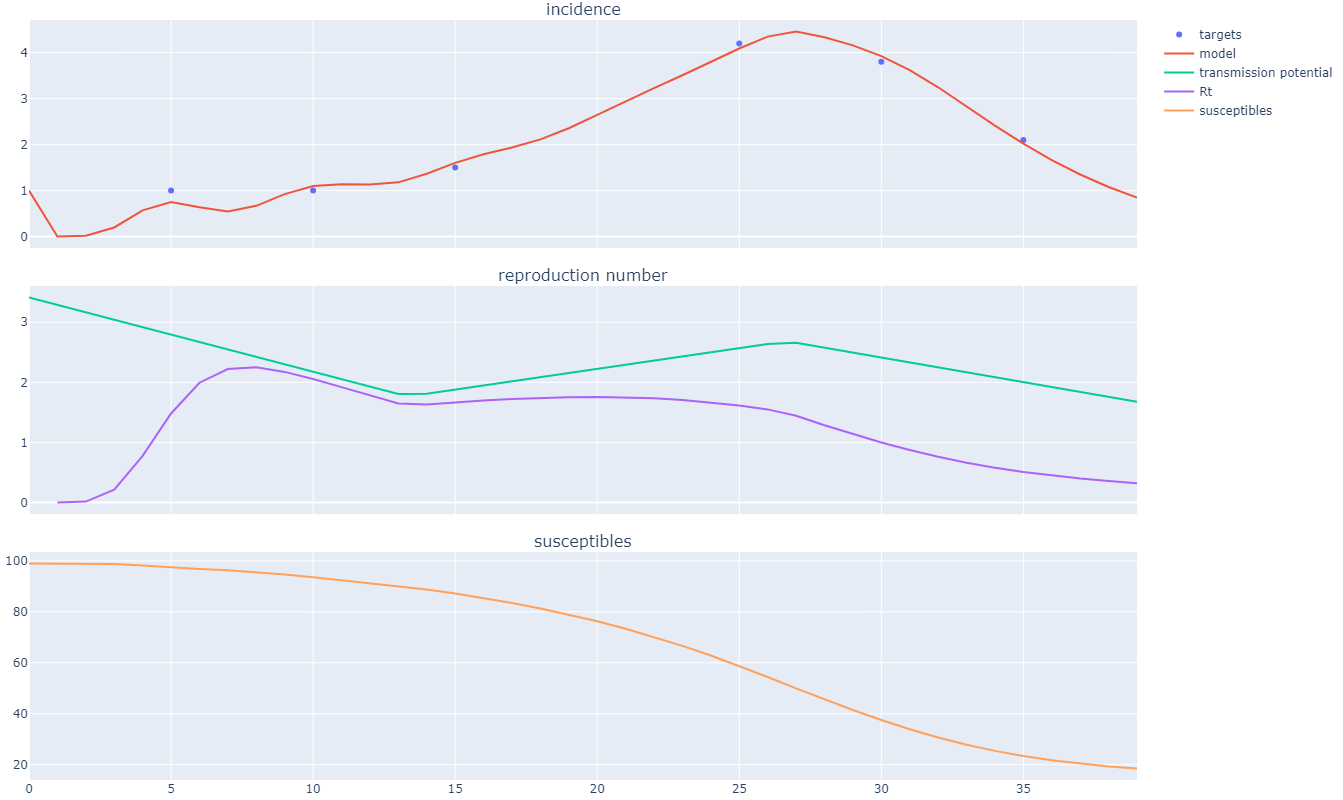

In [6]:
n_times = 40
infectious_seed = 1.0
population = 100.0
dummy_data = pd.Series(
    {
        5: 1.0,
        10: 1.0,
        15: 1.5,
        25: 4.2,
        30: 3.8,
        35: 2.1,
    },
)
param_bounds = [[0.0, 10.0]] * 4
gen_time_mean = 5.5
gen_time_sd = 1.7
max_gen_mean = 6.0
max_gen_sd = 2.0

# Calculate the longest distribution we could be interested in outside of the model function,
# otherwise if this is allowed to adapt to the distribution, things seem to go haywire
long_gen_densities = get_gamma_densities_from_params(max_gen_mean, max_gen_sd, n_times)
gen_times_end = np.argmax(long_gen_densities.cumsum() > 0.999)

param_bounds = [[5.0, max_gen_mean]] + [[1.5, max_gen_sd]] + [[0.0, 10.0]] * 4
result = minimize(all_param_calib_func, [5.0, 1.5] + [2.0] * 4, method='Nelder-Mead', args=(population, infectious_seed, n_times, dummy_data), bounds=param_bounds)
model_result, process_vals = model_func(result.x[0], result.x[1], result.x[2:], population, infectious_seed, n_times, gen_times_end)
optimised, suscept, r_t = model_result
plot_output_fit(dummy_data.to_dict(), model_result, process_vals)

In [7]:
gen_times_end

14